# ** IMPORT PACKAGES: **

In [1]:
# python peripherals
import os
import random
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

# scipy
import scipy.io
import scipy.stats as ss

# numpy
import numpy

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.ticker as ticker

# pytorch
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader

# ipython
from IPython.display import display, HTML

# deep signature
from deep_signature.utils import utils
from deep_signature.data_generation.curve_generation import LevelCurvesGenerator
from deep_signature.data_manipulation import curve_processing
from deep_signature.nn.datasets import DeepSignatureTupletsDataset
from deep_signature.nn.networks import DeepSignatureArcLengthNet
from deep_signature.nn.losses import ContrastiveLoss
from deep_signature.nn.trainers import ModelTrainer
from deep_signature.data_manipulation import curve_sampling
from deep_signature.data_manipulation import curve_processing

# common
from common import settings


# ** HELPER FUNCTIONS: **

In [2]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

# https://stackoverflow.com/questions/36074455/python-matplotlib-with-a-line-color-gradient-and-colorbar
def colorline(ax, x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = numpy.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = numpy.array([z])

    z = numpy.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    # ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = numpy.array([x, y]).T.reshape(-1, 1, 2)
    segments = numpy.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def plot_dist(ax, dist):
    x = numpy.array(range(dist.shape[0]))
    y = dist
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    colorline(ax=ax, x=x, y=y, cmap='hsv')

def plot_curve_sample(ax, curve, curve_sample, indices, zorder, point_size=10, alpha=1, cmap='hsv'):
    x = curve_sample[:, 0]
    y = curve_sample[:, 1]
    c = numpy.linspace(0.0, 1.0, curve.shape[0])

    ax.scatter(
        x=x,
        y=y,
        c=c[indices],
        s=point_size,
        cmap=cmap,
        alpha=alpha,
        norm=plt.Normalize(0.0, 1.0),
        zorder=zorder)

def plot_curve_section_center_point(ax, x, y, zorder, radius=1, color='white'):
    circle = plt.Circle((x, y), radius=radius, color=color, zorder=zorder)
    ax.add_artist(circle)

def plot_curve(ax, curve, linewidth=2, color='red', alpha=1):
    x = curve[:, 0]
    y = curve[:, 1]
    ax.plot(x, y, linewidth=linewidth, color=color, alpha=alpha)

def plot_curvature(ax, curvature, color='red', linewidth=2):
    x = range(curvature.shape[0])
    y = curvature
    ax.plot(x, y, color=color, linewidth=linewidth)

def plot_sample(ax, sample, color, zorder, point_size=10, alpha=1):
    x = sample[:, 0]
    y = sample[:, 1]

    ax.scatter(
        x=x,
        y=y,
        s=point_size,
        color=color,
        alpha=alpha,
        zorder=zorder)

def all_subdirs_of(b='.'):
  result = []
  for d in os.listdir(b):
    bd = os.path.join(b, d)
    if os.path.isdir(bd): result.append(bd)
  return result

# ** GLOBAL SETTINGS: **

In [3]:
plt.style.use("dark_background")

# ** SANITY CHECK - CURVES: **

In [ ]:
curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
limit = 10
color_map = plt.get_cmap('rainbow', limit)
for i, curve in enumerate(curves[:limit]): 
    fig, ax = plt.subplots(1, 1, figsize=(80,40))
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(30)
    ax.axis('equal')
    plot_curve(ax=ax, curve=curve, linewidth=5)
    plt.show()

# ** SANITY CHECK - DATASET PAIRS **

In [ ]:
dataset = DeepSignatureTupletsDataset()
dataset.load_dataset(dir_path=settings.level_curves_arclength_tuplets_dir_path)
dataset_size = len(dataset)
indices = list(range(dataset_size))
# numpy.random.shuffle(indices)
sampler = SubsetRandomSampler(indices)
data_loader = DataLoader(dataset, batch_size=1, sampler=sampler)

display(HTML('<h3>Random sample of tuplets:</h3>'))
for tuplet_index, data in enumerate(data_loader, 0):
    if tuplet_index == 35:
        break

    curve1 = torch.squeeze(torch.squeeze(data['input'])[0])
    curve2 = torch.squeeze(torch.squeeze(data['input'])[1])
    curve3 = torch.squeeze(torch.squeeze(data['input'])[2])
    # curve4 = torch.squeeze(torch.squeeze(data['input'])[3])

    display(HTML(f'<h3>Sample #{tuplet_index}:</h3>'))

    curve1 = curve1.cpu().numpy()
    curve2 = curve2.cpu().numpy()
    curve3 = curve3.cpu().numpy()
    # curve4 = curve4.cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.axis('equal')

    # print(data['curve'][0].shape)
    # print(data['anchor_indices'][0].cpu().numpy())
    # print(data['positive_indices1'][0].cpu().numpy())
    # print(data['positive_indices2'][0].cpu().numpy())

    # plot_curve(ax=ax, curve=data['curve'][0].cpu().numpy(), linewidth=2)

    plot_sample(
        ax=ax, 
        sample=curve1, 
        point_size=30,
        color='lightcoral',
        zorder=150)

    plot_sample(
        ax=ax, 
        sample=curve2, 
        point_size=20,
        color='skyblue',
        zorder=50)

    plot_sample(
        ax=ax, 
        sample=curve3, 
        point_size=20,
        color='springgreen',
        zorder=50)

    # print(curve1)
    # print(curve2)
    # print(curve3)

    # plot_sample(
    #     ax=ax, 
    #     sample=curve4, 
    #     point_size=50,
    #     color='gold',
    #     zorder=50)

    # plot_sample(ax, numpy.array([[0,0]]), point_size=50, alpha=1, color='white', zorder=100)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)
    
    plt.show()

# ** TRAIN/VALIDATION LOSS **

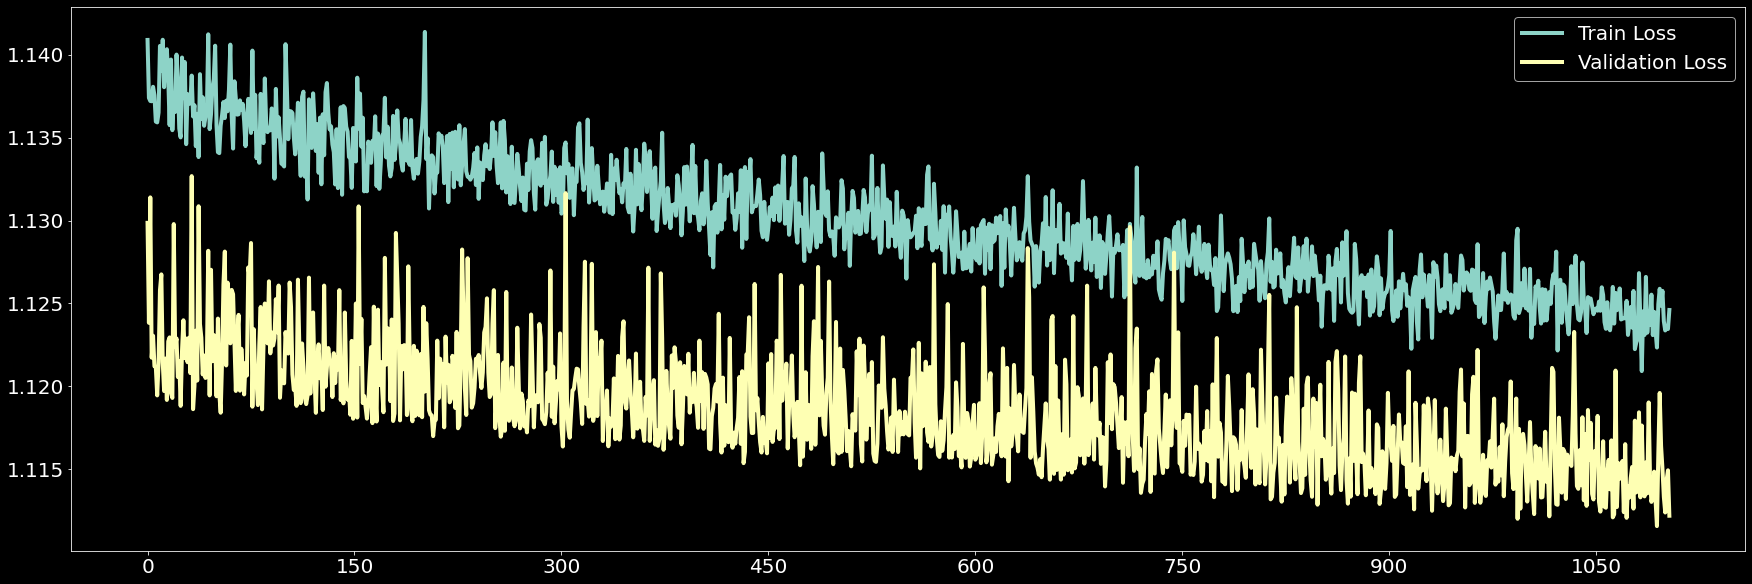

In [43]:
all_subdirs = all_subdirs_of(settings.level_curves_arclength_tuplets_results_dir_path)
latest_subdir = os.path.normpath(max(all_subdirs, key=os.path.getmtime))
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()

# results2 = numpy.load(f"C:/deep-signature-data/level-curves/results/tuplets/arclength/2021-01-14-02-42-52/results.npy", allow_pickle=True).item()

epochs = results['epochs']
batch_size = results['batch_size']
train_loss_array = results['train_loss_array'][1:]
validation_loss_array = results['validation_loss_array'][1:]

# train_loss_array2 = results2['train_loss_array']
# validation_loss_array2 = results2['validation_loss_array']

epochs_list = numpy.array(range(len(train_loss_array)))
# epochs_list2 = numpy.array(range(len(train_loss_array2)))

fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

ax.plot(epochs_list, train_loss_array, label='Train Loss', linewidth=4.0)
ax.plot(epochs_list, validation_loss_array, label='Validation Loss', linewidth=4.0)

# ax.plot(epochs_list2, train_loss_array2, label='Train Loss2', linewidth=4.0)
# ax.plot(epochs_list2, validation_loss_array2, label='Validation Loss2', linewidth=4.0)

plt.legend(fontsize=20, title_fontsize=20)

# print(train_loss_array)
# print(validation_loss_array)
plt.show()

# ** TEST MODEL **

------------ 4 + 5 -----------
[[0.02613015]]
[[0.06222124]]
[[0.05226029]]
-----------------------
[[0.02545085]]
[[0.03469812]]
[[0.06014898]]
[[0.06039839]]
-----------------------
[[0.0261544]]
[[0.02683746]]
[[0.02756824]]
[[0.02838918]]
[[0.02906035]]
[[0.0298527]]
[[0.03076428]]
[[0.03166496]]
[[0.03251087]]
[[0.03335715]]
[[0.03440856]]
[[0.03517004]]
[[0.0361179]]
[[0.03731305]]
[[0.03805897]]
[[0.03902529]]
[[0.03991415]]
[[0.04075574]]
[[0.04153113]]
[[0.0423661]]
[[0.04298647]]
[[0.04424182]]
[[0.04524235]]
[[0.04610321]]
[[0.04694467]]
[[0.04786664]]
[[0.04902636]]
[[0.05022039]]
[[0.05112051]]
[[0.05219089]]
[[0.05292432]]
[[0.05403177]]
[[0.05479643]]
[[0.05601212]]
[[0.05683796]]
[[0.05761286]]
[[0.05855085]]
[[0.05937095]]
[[0.06028272]]
[[0.06112729]]
[[0.06215112]]
[[0.06298009]]
[[0.06376722]]
[[0.06418809]]
[[0.06572037]]
[[0.06675702]]
[[0.06713997]]
[[0.06772243]]
[[0.06857216]]
[[0.07012724]]
[[0.07007411]]
[[0.07062064]]
[[0.07161443]]
[[0.072198]]
[[0.07296693

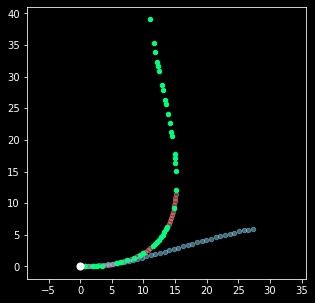

------------ 4 + 5 -----------
[[0.03931109]]
[[0.07938039]]
[[0.07862217]]
-----------------------
[[0.0382945]]
[[0.03918003]]
[[0.07747453]]
[[0.07738238]]
-----------------------
[[0.03929423]]
[[0.04032291]]
[[0.04132087]]
[[0.04235467]]
[[0.04337688]]
[[0.0443913]]
[[0.04544751]]
[[0.04638442]]
[[0.04740956]]
[[0.04837848]]
[[0.04936948]]
[[0.0502953]]
[[0.05134392]]
[[0.0523329]]
[[0.05342196]]
[[0.05448622]]
[[0.05550854]]
[[0.05641159]]
[[0.05745093]]
[[0.05855888]]
[[0.05958605]]
[[0.06051917]]
[[0.06147439]]
[[0.06251001]]
[[0.06361773]]
[[0.06451951]]
[[0.0656218]]
[[0.0665939]]
[[0.06772992]]
[[0.068675]]
[[0.06961516]]
[[0.07050616]]
[[0.07156407]]
[[0.07242004]]
[[0.07349634]]
[[0.07439867]]
[[0.07545046]]
[[0.07644862]]
[[0.07734471]]
[[0.07834188]]
[[0.07940819]]
[[0.0802506]]
[[0.08129615]]
[[0.08223105]]
[[0.08320134]]
[[0.0841101]]
[[0.08506388]]
[[0.08601206]]
[[0.08691467]]
[[0.0879126]]
[[0.08877234]]
[[0.08977909]]
[[0.09074257]]
[[0.09166874]]
[[0.09244345]]
[[

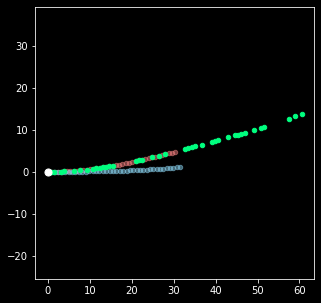

------------ 4 + 5 -----------
[[0.04164479]]
[[0.08316866]]
[[0.08328958]]
-----------------------
[[0.04061543]]
[[0.04050045]]
[[0.08111588]]
[[0.08108344]]
-----------------------
[[0.04164188]]
[[0.04269452]]
[[0.043741]]
[[0.0447727]]
[[0.04577297]]
[[0.04679986]]
[[0.04785803]]
[[0.04881681]]
[[0.04986393]]
[[0.05088059]]
[[0.05181478]]
[[0.05290121]]
[[0.05394284]]
[[0.05504738]]
[[0.05604888]]
[[0.05711031]]
[[0.05809945]]
[[0.05911268]]
[[0.06019863]]
[[0.06133961]]
[[0.06240573]]
[[0.06318942]]
[[0.06448441]]
[[0.06562658]]
[[0.06666764]]
[[0.06761184]]
[[0.06861133]]
[[0.0697907]]
[[0.07060098]]
[[0.07173762]]
[[0.07276689]]
[[0.07375951]]
[[0.07473459]]
[[0.07583978]]
[[0.0768611]]
[[0.07794719]]
[[0.07896373]]
[[0.07996684]]
[[0.081051]]
[[0.08198883]]
[[0.08329626]]
[[0.08424236]]
[[0.08540769]]
[[0.08642886]]
[[0.08747834]]
[[0.08855091]]
[[0.08959479]]
[[0.09067421]]
[[0.09178005]]
[[0.09286589]]
[[0.09388796]]
[[0.0948942]]
[[0.09589949]]
[[0.09691]]
[[0.09806795]]
[[

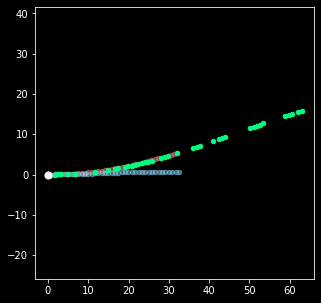

------------ 4 + 5 -----------
[[0.03441148]]
[[0.07522185]]
[[0.06882297]]
-----------------------
[[0.03344803]]
[[0.03988719]]
[[0.07333522]]
[[0.07321936]]
-----------------------
[[0.03445819]]
[[0.03540248]]
[[0.03640734]]
[[0.03737879]]
[[0.03838697]]
[[0.03937056]]
[[0.04038838]]
[[0.04134418]]
[[0.04227654]]
[[0.04321129]]
[[0.04435822]]
[[0.0453897]]
[[0.04626371]]
[[0.04721397]]
[[0.04836705]]
[[0.04934089]]
[[0.05037895]]
[[0.05135803]]
[[0.05250189]]
[[0.05345017]]
[[0.05450091]]
[[0.05554119]]
[[0.05666405]]
[[0.05768906]]
[[0.05865325]]
[[0.05974563]]
[[0.06082575]]
[[0.06174176]]
[[0.06277765]]
[[0.063845]]
[[0.06501175]]
[[0.06604651]]
[[0.06699755]]
[[0.06816571]]
[[0.0691128]]
[[0.07024768]]
[[0.07127259]]
[[0.07228197]]
[[0.07315225]]
[[0.0741429]]
[[0.07522889]]
[[0.07626026]]
[[0.07725472]]
[[0.07831483]]
[[0.07937414]]
[[0.08055299]]
[[0.0817626]]
[[0.08274497]]
[[0.08373685]]
[[0.0846506]]
[[0.08574783]]
[[0.08663438]]
[[0.08755059]]
[[0.08853939]]
[[0.08947605]

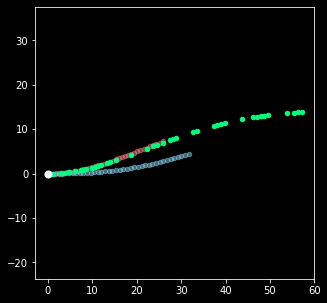

------------ 4 + 5 -----------
[[0.04409072]]
[[0.08663802]]
[[0.08818143]]
-----------------------
[[0.04298271]]
[[0.04169641]]
[[0.08467913]]
[[0.08477472]]
-----------------------
[[0.04409635]]
[[0.04520732]]
[[0.04629491]]
[[0.04739417]]
[[0.04846791]]
[[0.04953625]]
[[0.05062246]]
[[0.0517032]]
[[0.05282127]]
[[0.05395348]]
[[0.05504703]]
[[0.05616634]]
[[0.05719513]]
[[0.05838008]]
[[0.0593157]]
[[0.06058056]]
[[0.06167372]]
[[0.06265622]]
[[0.06394049]]
[[0.06482748]]
[[0.06596941]]
[[0.06705988]]
[[0.06819316]]
[[0.06922475]]
[[0.07015051]]
[[0.07121111]]
[[0.07227327]]
[[0.07336899]]
[[0.07441589]]
[[0.07547429]]
[[0.07642462]]
[[0.07754513]]
[[0.07855783]]
[[0.07970425]]
[[0.08062766]]
[[0.0815886]]
[[0.08277087]]
[[0.0836608]]
[[0.08465983]]
[[0.08565987]]
[[0.08671636]]
[[0.08763613]]
[[0.08863502]]
[[0.08956109]]
[[0.09048574]]
[[0.09147568]]
[[0.09245775]]
[[0.09329579]]
[[0.09436011]]
[[0.09509679]]
[[0.09602262]]
[[0.0969524]]
[[0.09794291]]
[[0.09900052]]
[[0.0997626

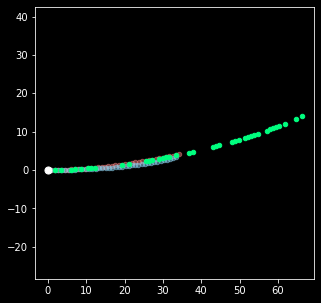

------------ 4 + 5 -----------
[[0.041923]]
[[0.07987736]]
[[0.08384599]]
-----------------------
[[0.04091867]]
[[0.03721395]]
[[0.07813262]]
[[0.07819309]]
-----------------------
[[0.04194475]]
[[0.04293557]]
[[0.04392537]]
[[0.04492712]]
[[0.04589479]]
[[0.04691472]]
[[0.04784722]]
[[0.04881811]]
[[0.04978071]]
[[0.05067998]]
[[0.05167196]]
[[0.05265204]]
[[0.05363448]]
[[0.05457336]]
[[0.05562747]]
[[0.05657825]]
[[0.05761412]]
[[0.05856839]]
[[0.05954447]]
[[0.06045337]]
[[0.06133194]]
[[0.0622903]]
[[0.06344612]]
[[0.06421482]]
[[0.06535391]]
[[0.0663447]]
[[0.06710074]]
[[0.06814466]]
[[0.06908809]]
[[0.06994538]]
[[0.07098188]]
[[0.07182401]]
[[0.07271478]]
[[0.07366096]]
[[0.07455803]]
[[0.07546091]]
[[0.07639426]]
[[0.07723369]]
[[0.07816607]]
[[0.07895511]]
[[0.08009414]]
[[0.08076181]]
[[0.08173204]]
[[0.08266242]]
[[0.08360694]]
[[0.08450238]]
[[0.08521746]]
[[0.08620169]]
[[0.08715101]]
[[0.0879977]]
[[0.08880242]]
[[0.08973286]]
[[0.09057874]]
[[0.09140568]]
[[0.0923578

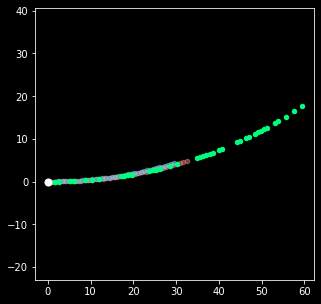

------------ 4 + 5 -----------
[[0.03802485]]
[[0.07506749]]
[[0.0760497]]
-----------------------
[[0.03709472]]
[[0.03604908]]
[[0.07314381]]
[[0.07329853]]
-----------------------
[[0.03801858]]
[[0.03893094]]
[[0.03984771]]
[[0.04077402]]
[[0.04170016]]
[[0.04263059]]
[[0.04352381]]
[[0.04444959]]
[[0.04536636]]
[[0.04631466]]
[[0.04719733]]
[[0.04807254]]
[[0.04902208]]
[[0.0499293]]
[[0.0508197]]
[[0.05168348]]
[[0.05259429]]
[[0.05358351]]
[[0.05444546]]
[[0.0554246]]
[[0.05634408]]
[[0.05739409]]
[[0.05817088]]
[[0.05923793]]
[[0.06012871]]
[[0.06111833]]
[[0.0619397]]
[[0.06282351]]
[[0.06389512]]
[[0.06446428]]
[[0.06597812]]
[[0.06659645]]
[[0.06763674]]
[[0.06853547]]
[[0.06947348]]
[[0.07032444]]
[[0.07143921]]
[[0.07231389]]
[[0.07327029]]
[[0.07415249]]
[[0.07503438]]
[[0.07605046]]
[[0.07695785]]
[[0.07800638]]
[[0.07884834]]
[[0.07976385]]
[[0.08062095]]
[[0.08158317]]
[[0.08243526]]
[[0.08327889]]
[[0.08437569]]
[[0.08531506]]
[[0.08640881]]
[[0.0872535]]
[[0.0881212]

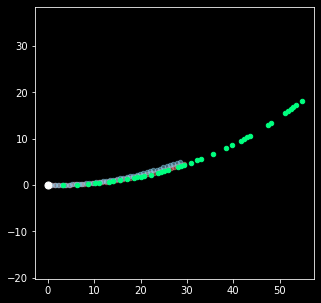

------------ 4 + 5 -----------
[[0.03799587]]
[[0.0750092]]
[[0.07599174]]
-----------------------
[[0.03706311]]
[[0.03605111]]
[[0.07311422]]
[[0.07312671]]
-----------------------
[[0.03801281]]
[[0.03894585]]
[[0.03989855]]
[[0.04079093]]
[[0.04178323]]
[[0.04270554]]
[[0.0436768]]
[[0.04458688]]
[[0.0455653]]
[[0.04650047]]
[[0.04742479]]
[[0.04829324]]
[[0.04928223]]
[[0.05028495]]
[[0.05124269]]
[[0.05208434]]
[[0.053083]]
[[0.0540376]]
[[0.0548745]]
[[0.05589339]]
[[0.05676552]]
[[0.05758849]]
[[0.05859624]]
[[0.0594844]]
[[0.06025422]]
[[0.06110553]]
[[0.06205132]]
[[0.06296007]]
[[0.06381084]]
[[0.06476095]]
[[0.06581715]]
[[0.06666813]]
[[0.06782109]]
[[0.06854327]]
[[0.06966535]]
[[0.07039451]]
[[0.07143284]]
[[0.07230695]]
[[0.07312029]]
[[0.07411892]]
[[0.0750259]]
[[0.07583866]]
[[0.07676264]]
[[0.07769367]]
[[0.07882216]]
[[0.07948064]]
[[0.08039113]]
[[0.08153465]]
[[0.08209204]]
[[0.08324734]]
[[0.0838832]]
[[0.08493129]]
[[0.0859336]]
[[0.08696532]]
[[0.08776041]]
[[

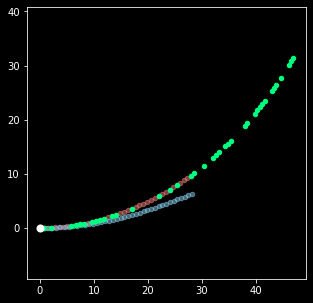

------------ 4 + 5 -----------
[[0.03774143]]
[[0.07508199]]
[[0.07548286]]
-----------------------
[[0.03680757]]
[[0.03644694]]
[[0.07325451]]
[[0.0732443]]
-----------------------
[[0.03774158]]
[[0.03866344]]
[[0.03957293]]
[[0.04049885]]
[[0.04145574]]
[[0.0424073]]
[[0.04332075]]
[[0.04421887]]
[[0.04521087]]
[[0.0461461]]
[[0.04706999]]
[[0.04794541]]
[[0.04890025]]
[[0.0498039]]
[[0.05071055]]
[[0.05174566]]
[[0.05266602]]
[[0.05373571]]
[[0.05467981]]
[[0.05548505]]
[[0.05644603]]
[[0.057423]]
[[0.05841145]]
[[0.05937393]]
[[0.06036444]]
[[0.06125396]]
[[0.06216048]]
[[0.06305237]]
[[0.0639783]]
[[0.06485165]]
[[0.06585181]]
[[0.06682283]]
[[0.06783914]]
[[0.06858881]]
[[0.0696302]]
[[0.0706711]]
[[0.07133863]]
[[0.07247541]]
[[0.07316483]]
[[0.07427488]]
[[0.07509716]]
[[0.07616787]]
[[0.07703917]]
[[0.07806753]]
[[0.07882947]]
[[0.07972554]]
[[0.08070143]]
[[0.08169046]]
[[0.0827206]]
[[0.08378672]]
[[0.08453642]]
[[0.08559596]]
[[0.08644987]]
[[0.08735903]]
[[0.08817664]]
[

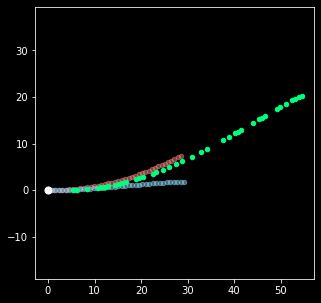

------------ 4 + 5 -----------
[[0.02337622]]
[[0.04385682]]
[[0.04675243]]
-----------------------
[[0.02254609]]
[[0.02068576]]
[[0.04323185]]
[[0.04332904]]
-----------------------
[[0.02334583]]
[[0.02414794]]
[[0.02501292]]
[[0.02569811]]
[[0.0265453]]
[[0.02717745]]
[[0.02807598]]
[[0.02857491]]
[[0.02941506]]
[[0.03006719]]
[[0.03077261]]
[[0.0314827]]
[[0.03240868]]
[[0.03288518]]
[[0.03353398]]
[[0.03444421]]
[[0.03505678]]
[[0.03542178]]
[[0.03614717]]
[[0.03673508]]
[[0.03704067]]
[[0.03779633]]
[[0.03804016]]
[[0.03914387]]
[[0.03914121]]
[[0.03944075]]
[[0.04057222]]
[[0.04020985]]
[[0.04103543]]
[[0.04080599]]
[[0.04158685]]
[[0.04164185]]
[[0.04169467]]
[[0.04223392]]
[[0.042477]]
[[0.04256052]]
[[0.04253928]]
[[0.0431947]]
[[0.04303895]]
[[0.04362889]]
[[0.04394325]]
[[0.04412478]]
[[0.04485563]]
[[0.04443861]]
[[0.04534308]]
[[0.04506829]]
[[0.04603039]]
[[0.04628415]]
[[0.04701919]]
[[0.04770039]]
[[0.04705383]]
[[0.04808846]]
[[0.04884799]]
[[0.04892198]]
[[0.0507778

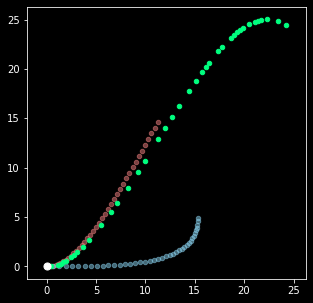

------------ 4 + 5 -----------
[[0.03379453]]
[[0.06849022]]
[[0.06758907]]
-----------------------
[[0.03292751]]
[[0.03380938]]
[[0.06673688]]
[[0.0666404]]
-----------------------
[[0.03383871]]
[[0.03467612]]
[[0.03554701]]
[[0.036477]]
[[0.03732907]]
[[0.03810592]]
[[0.03896564]]
[[0.03978296]]
[[0.0406618]]
[[0.04156426]]
[[0.04242801]]
[[0.04318842]]
[[0.04418268]]
[[0.04496377]]
[[0.04586968]]
[[0.0467248]]
[[0.04739733]]
[[0.0484614]]
[[0.0491144]]
[[0.04984385]]
[[0.05090099]]
[[0.05165444]]
[[0.05269124]]
[[0.05341474]]
[[0.05439604]]
[[0.05521792]]
[[0.05618299]]
[[0.05706088]]
[[0.05784037]]
[[0.05869064]]
[[0.05953512]]
[[0.06040066]]
[[0.06129544]]
[[0.06228517]]
[[0.06300108]]
[[0.06394082]]
[[0.06478742]]
[[0.06590035]]
[[0.06662559]]
[[0.06760623]]
[[0.06849434]]
[[0.0693953]]
[[0.07017717]]
[[0.07144312]]
[[0.07220409]]
[[0.07315334]]
[[0.07404176]]
[[0.07523832]]
[[0.07574347]]
[[0.07658455]]
[[0.07791498]]
[[0.07873835]]
[[0.07960518]]
[[0.08067174]]
[[0.08106749]]

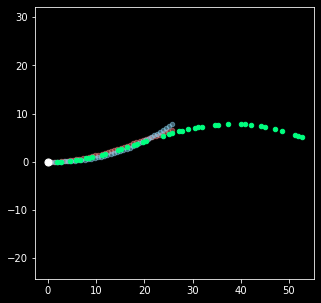

------------ 4 + 5 -----------
[[0.027882]]
[[0.06543496]]
[[0.055764]]
-----------------------
[[0.02696224]]
[[0.0365587]]
[[0.06352094]]
[[0.0635774]]
-----------------------
[[0.02788569]]
[[0.02877148]]
[[0.02972427]]
[[0.03064582]]
[[0.03157353]]
[[0.03244986]]
[[0.03345518]]
[[0.03436396]]
[[0.03532576]]
[[0.03625859]]
[[0.03725683]]
[[0.03825625]]
[[0.03930474]]
[[0.04042472]]
[[0.04111919]]
[[0.0422663]]
[[0.04329637]]
[[0.04400263]]
[[0.04506066]]
[[0.04605119]]
[[0.04701966]]
[[0.04799837]]
[[0.04884257]]
[[0.04979633]]
[[0.05110899]]
[[0.05175954]]
[[0.05266479]]
[[0.05393507]]
[[0.05442653]]
[[0.05539399]]
[[0.05646989]]
[[0.05737407]]
[[0.05828199]]
[[0.05935952]]
[[0.05967748]]
[[0.06090406]]
[[0.06164558]]
[[0.06269966]]
[[0.06361552]]
[[0.06459371]]
[[0.06503785]]
[[0.06613934]]
[[0.06709832]]
[[0.06775303]]
[[0.06842082]]
[[0.06904768]]
[[0.06991356]]
[[0.0706381]]
[[0.07122588]]
[[0.07196821]]
[[0.07326757]]
[[0.07361091]]
[[0.07430034]]
[[0.07494076]]
[[0.07575314]]

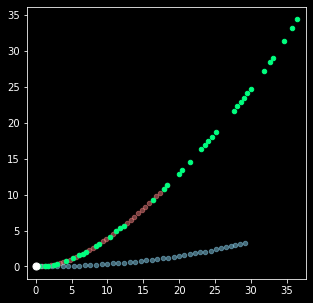

------------ 4 + 5 -----------
[[0.02302257]]
[[0.06166163]]
[[0.04604513]]
-----------------------
[[0.02197804]]
[[0.03747135]]
[[0.0594494]]
[[0.05936742]]
-----------------------
[[0.02299506]]
[[0.02399856]]
[[0.02498173]]
[[0.02598008]]
[[0.0269268]]
[[0.02807049]]
[[0.02913226]]
[[0.03016095]]
[[0.03104551]]
[[0.03234159]]
[[0.03315744]]
[[0.03415246]]
[[0.03523009]]
[[0.03648509]]
[[0.03740906]]
[[0.03839628]]
[[0.03956812]]
[[0.04051745]]
[[0.04152533]]
[[0.04237526]]
[[0.04372771]]
[[0.0445812]]
[[0.0458673]]
[[0.04661253]]
[[0.04777888]]
[[0.04892085]]
[[0.04955458]]
[[0.05052721]]
[[0.05142055]]
[[0.05201822]]
[[0.05325739]]
[[0.05410984]]
[[0.05492678]]
[[0.05550873]]
[[0.05640736]]
[[0.0574633]]
[[0.05834735]]
[[0.05931874]]
[[0.05990511]]
[[0.06055202]]
[[0.06094399]]
[[0.06254579]]
[[0.06258053]]
[[0.06278449]]
[[0.0636259]]
[[0.06581193]]
[[0.0644461]]
[[0.06541103]]
[[0.06608296]]
[[0.0660662]]
[[0.06632899]]
[[0.06730137]]
[[0.06722885]]
[[0.06929734]]
[[0.06832249]]

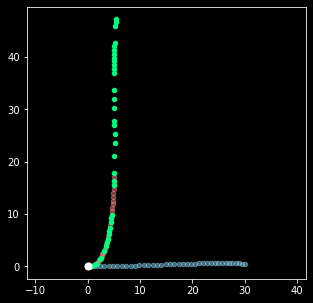

------------ 4 + 5 -----------
[[0.02586489]]
[[0.05122234]]
[[0.05172978]]
-----------------------
[[0.02517554]]
[[0.02463391]]
[[0.04980945]]
[[0.04992879]]
-----------------------
[[0.02587538]]
[[0.02654876]]
[[0.02725788]]
[[0.02787605]]
[[0.02859593]]
[[0.02924209]]
[[0.0298219]]
[[0.03051]]
[[0.03116692]]
[[0.03193242]]
[[0.03249922]]
[[0.03306159]]
[[0.03384045]]
[[0.03442815]]
[[0.03503298]]
[[0.03567553]]
[[0.03638677]]
[[0.03696977]]
[[0.0376717]]
[[0.03832095]]
[[0.03897576]]
[[0.03956315]]
[[0.04034711]]
[[0.0407116]]
[[0.0415008]]
[[0.04208435]]
[[0.04269598]]
[[0.04318127]]
[[0.04404131]]
[[0.04423479]]
[[0.04491981]]
[[0.04558139]]
[[0.04627454]]
[[0.04700227]]
[[0.04739433]]
[[0.04813203]]
[[0.04850255]]
[[0.04912578]]
[[0.05011345]]
[[0.05048578]]
[[0.05120436]]
[[0.05176799]]
[[0.05227647]]
[[0.05298788]]
[[0.05364612]]
[[0.05414229]]
[[0.05461983]]
[[0.0551705]]
[[0.05588918]]
[[0.05648117]]
[[0.05741562]]
[[0.05758754]]
[[0.05841743]]
[[0.05869224]]
[[0.0593239]]


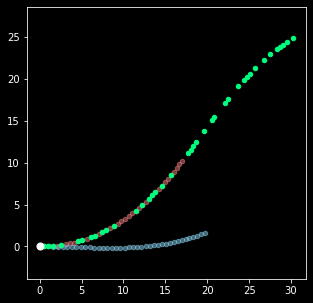

------------ 4 + 5 -----------
[[0.01857147]]
[[0.03733116]]
[[0.03714295]]
-----------------------
[[0.01808897]]
[[0.01815166]]
[[0.03624062]]
[[0.03643803]]
-----------------------
[[0.018543]]
[[0.01900977]]
[[0.01942675]]
[[0.01991739]]
[[0.02023014]]
[[0.02074908]]
[[0.02117902]]
[[0.02151954]]
[[0.02213415]]
[[0.02241107]]
[[0.02285127]]
[[0.02331023]]
[[0.023813]]
[[0.0242675]]
[[0.02475512]]
[[0.02520238]]
[[0.02565581]]
[[0.02612205]]
[[0.02655286]]
[[0.02685026]]
[[0.02729802]]
[[0.02798233]]
[[0.0284489]]
[[0.0288838]]
[[0.02942013]]
[[0.0300187]]
[[0.03025191]]
[[0.03066959]]
[[0.03148476]]
[[0.03195472]]
[[0.03243837]]
[[0.03296096]]
[[0.03347757]]
[[0.0339099]]
[[0.03451907]]
[[0.03491096]]
[[0.03551044]]
[[0.03582658]]
[[0.03642644]]
[[0.03694894]]
[[0.03736892]]
[[0.03790827]]
[[0.03818136]]
[[0.03869113]]
[[0.03912187]]
[[0.03974194]]
[[0.04015905]]
[[0.04046899]]
[[0.04071746]]
[[0.04121861]]
[[0.04184922]]
[[0.04185212]]
[[0.04226472]]
[[0.04275201]]
[[0.04306724]]


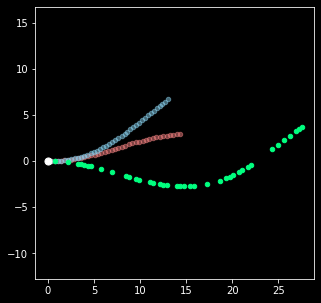

------------ 4 + 5 -----------
[[0.04641713]]
[[0.08821029]]
[[0.09283427]]
-----------------------
[[0.045291]]
[[0.04097599]]
[[0.08626698]]
[[0.08633996]]
-----------------------
[[0.04640196]]
[[0.04752439]]
[[0.04859901]]
[[0.04970084]]
[[0.05077141]]
[[0.05190728]]
[[0.05300226]]
[[0.05411697]]
[[0.05525745]]
[[0.05644819]]
[[0.05755069]]
[[0.05857305]]
[[0.05970052]]
[[0.06080246]]
[[0.06192687]]
[[0.0629615]]
[[0.06402982]]
[[0.06513251]]
[[0.0662183]]
[[0.06707463]]
[[0.06821643]]
[[0.0692902]]
[[0.07036773]]
[[0.07134214]]
[[0.07229131]]
[[0.07343774]]
[[0.07448244]]
[[0.07544133]]
[[0.07645305]]
[[0.07746541]]
[[0.07841903]]
[[0.07945186]]
[[0.08049757]]
[[0.08150631]]
[[0.08242232]]
[[0.08335909]]
[[0.08437575]]
[[0.08526913]]
[[0.08627919]]
[[0.08729191]]
[[0.08804296]]
[[0.08919499]]
[[0.09016344]]
[[0.0909363]]
[[0.09192908]]
[[0.09279979]]
[[0.09376966]]
[[0.09491669]]
[[0.09562121]]
[[0.09659833]]
[[0.09745295]]
[[0.0984323]]
[[0.09957455]]
[[0.09999783]]
[[0.10095577]

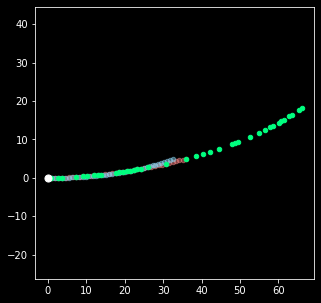

------------ 4 + 5 -----------
[[0.01793352]]
[[0.04931369]]
[[0.03586703]]
-----------------------
[[0.01760567]]
[[0.03035176]]
[[0.04795744]]
[[0.04831393]]
-----------------------
[[0.0179639]]
[[0.01838521]]
[[0.01881485]]
[[0.01930887]]
[[0.01981803]]
[[0.02054688]]
[[0.02097234]]
[[0.02179929]]
[[0.02273192]]
[[0.02337769]]
[[0.02359052]]
[[0.02479918]]
[[0.02548963]]
[[0.02655408]]
[[0.02771953]]
[[0.0286198]]
[[0.02950927]]
[[0.03051325]]
[[0.0310453]]
[[0.03220304]]
[[0.03280584]]
[[0.03372594]]
[[0.0348723]]
[[0.03522355]]
[[0.03616288]]
[[0.03727779]]
[[0.03812386]]
[[0.03881618]]
[[0.03909794]]
[[0.04023365]]
[[0.04131188]]
[[0.04250331]]
[[0.04313193]]
[[0.04379682]]
[[0.04433485]]
[[0.04606823]]
[[0.0463002]]
[[0.04705286]]
[[0.04798746]]
[[0.04814511]]
[[0.0497388]]
[[0.05046613]]
[[0.05127342]]
[[0.05170363]]
[[0.05276914]]
[[0.0535772]]
[[0.05386899]]
[[0.05503118]]
[[0.05568465]]
[[0.05635124]]
[[0.05680142]]
[[0.05837025]]
[[0.05865468]]
[[0.05936198]]
[[0.0603711]]

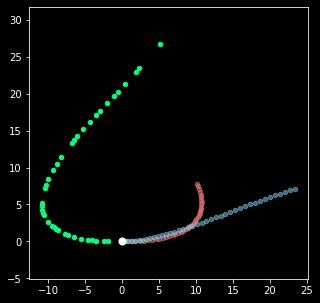

------------ 4 + 5 -----------
[[0.02889731]]
[[0.06558583]]
[[0.05779463]]
-----------------------
[[0.02802238]]
[[0.03572153]]
[[0.06374391]]
[[0.06400328]]
-----------------------
[[0.0289132]]
[[0.02980704]]
[[0.0307331]]
[[0.031598]]
[[0.0325674]]
[[0.03343317]]
[[0.03439754]]
[[0.03534447]]
[[0.03640347]]
[[0.03737737]]
[[0.03829142]]
[[0.03915036]]
[[0.04020882]]
[[0.04120782]]
[[0.04202131]]
[[0.04283663]]
[[0.04377689]]
[[0.04469869]]
[[0.0458722]]
[[0.04651569]]
[[0.04738413]]
[[0.0487037]]
[[0.04966934]]
[[0.05047866]]
[[0.05160784]]
[[0.05269987]]
[[0.05358429]]
[[0.05428258]]
[[0.05545882]]
[[0.05643777]]
[[0.05715505]]
[[0.05804152]]
[[0.05879201]]
[[0.05973986]]
[[0.06071002]]
[[0.06147797]]
[[0.06213225]]
[[0.06321947]]
[[0.06415745]]
[[0.06476191]]
[[0.06564136]]
[[0.06639041]]
[[0.06704593]]
[[0.06811165]]
[[0.06860713]]
[[0.06949297]]
[[0.07029899]]
[[0.07106481]]
[[0.07156132]]
[[0.07214636]]
[[0.0730889]]
[[0.07384457]]
[[0.07448567]]
[[0.07555269]]
[[0.07565913]]

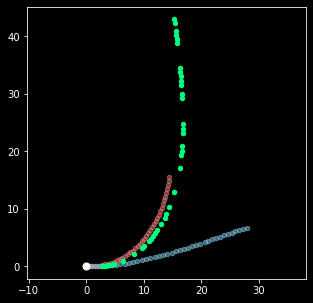

------------ 4 + 5 -----------
[[0.04455106]]
[[0.09492953]]
[[0.08910211]]
-----------------------
[[0.04324602]]
[[0.04955674]]
[[0.09280276]]
[[0.09286103]]
-----------------------
[[0.04456114]]
[[0.04583745]]
[[0.04718885]]
[[0.04851584]]
[[0.04984086]]
[[0.05121944]]
[[0.05249431]]
[[0.0538775]]
[[0.05519482]]
[[0.0565958]]
[[0.05802396]]
[[0.05933919]]
[[0.06068149]]
[[0.06206204]]
[[0.06335866]]
[[0.06457576]]
[[0.06586776]]
[[0.06717104]]
[[0.06853924]]
[[0.07013239]]
[[0.07125612]]
[[0.07246273]]
[[0.07371765]]
[[0.07518118]]
[[0.07625372]]
[[0.0777693]]
[[0.07881941]]
[[0.08012465]]
[[0.08120567]]
[[0.08257181]]
[[0.08374763]]
[[0.08492641]]
[[0.08611262]]
[[0.08734764]]
[[0.08842741]]
[[0.089476]]
[[0.09073246]]
[[0.09177106]]
[[0.09263057]]
[[0.09381553]]
[[0.09506693]]
[[0.09620349]]
[[0.09703986]]
[[0.0980221]]
[[0.09933107]]
[[0.1001973]]
[[0.10105623]]
[[0.1019829]]
[[0.10288082]]
[[0.10397893]]
[[0.10485466]]
[[0.10602465]]
[[0.10585799]]
[[0.10789321]]
[[0.10849026]]

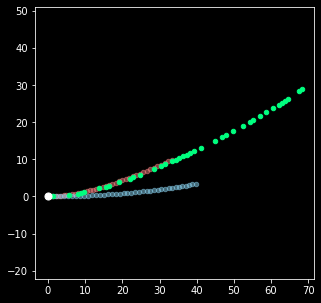

------------ 4 + 5 -----------
[[0.046464]]
[[0.08697295]]
[[0.09292801]]
-----------------------
[[0.04536089]]
[[0.0397928]]
[[0.08515369]]
[[0.08510451]]
-----------------------
[[0.04645924]]
[[0.0475708]]
[[0.04864364]]
[[0.04970741]]
[[0.05077362]]
[[0.05187367]]
[[0.05297333]]
[[0.05405064]]
[[0.05519044]]
[[0.05628174]]
[[0.05725144]]
[[0.05848614]]
[[0.05943735]]
[[0.06049847]]
[[0.06142823]]
[[0.06261272]]
[[0.06353766]]
[[0.06458254]]
[[0.06565307]]
[[0.06675076]]
[[0.06764624]]
[[0.06868173]]
[[0.06971073]]
[[0.07070859]]
[[0.07179514]]
[[0.07272537]]
[[0.07381503]]
[[0.07466198]]
[[0.07561562]]
[[0.07667003]]
[[0.07759981]]
[[0.07853146]]
[[0.07953812]]
[[0.08045171]]
[[0.08142371]]
[[0.08232327]]
[[0.08331882]]
[[0.08412363]]
[[0.08514168]]
[[0.08604028]]
[[0.08694694]]
[[0.08787635]]
[[0.0888152]]
[[0.08964027]]
[[0.0906286]]
[[0.09165955]]
[[0.09242313]]
[[0.09333486]]
[[0.09418197]]
[[0.09496014]]
[[0.09557648]]
[[0.09698108]]
[[0.09753301]]
[[0.09843627]]
[[0.09945031

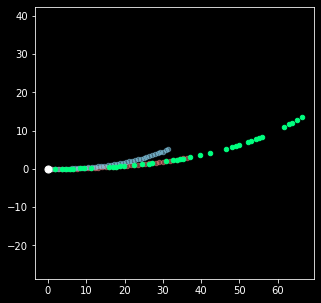

------------ 4 + 5 -----------
[[0.04779606]]
[[0.09160296]]
[[0.09559212]]
-----------------------
[[0.04658758]]
[[0.04314949]]
[[0.08973706]]
[[0.08969849]]
-----------------------
[[0.04780043]]
[[0.04899675]]
[[0.05020528]]
[[0.05141011]]
[[0.05267889]]
[[0.05392387]]
[[0.05506507]]
[[0.05640965]]
[[0.05741903]]
[[0.05860858]]
[[0.05988011]]
[[0.06119831]]
[[0.06225443]]
[[0.06346456]]
[[0.06460286]]
[[0.06573]]
[[0.06683111]]
[[0.06802171]]
[[0.0691298]]
[[0.07018704]]
[[0.0712683]]
[[0.07243344]]
[[0.07364916]]
[[0.07458215]]
[[0.07570328]]
[[0.07685372]]
[[0.07786516]]
[[0.07887223]]
[[0.07996312]]
[[0.08104872]]
[[0.08193473]]
[[0.08299325]]
[[0.08401452]]
[[0.08499452]]
[[0.08595534]]
[[0.08692872]]
[[0.08776655]]
[[0.08878282]]
[[0.0896786]]
[[0.09066839]]
[[0.09148842]]
[[0.09257247]]
[[0.09333967]]
[[0.09428096]]
[[0.09516487]]
[[0.09600642]]
[[0.09698261]]
[[0.09825106]]
[[0.09823602]]
[[0.09915351]]
[[0.10035078]]
[[0.10106537]]
[[0.10238321]]
[[0.10309009]]
[[0.10377897

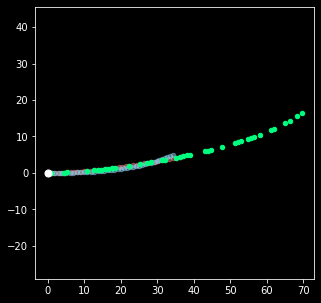

------------ 4 + 5 -----------
[[0.02855251]]
[[0.05210836]]
[[0.05710502]]
-----------------------
[[0.02776082]]
[[0.02311098]]
[[0.0508718]]
[[0.05099002]]
-----------------------
[[0.02855159]]
[[0.02930949]]
[[0.03007191]]
[[0.0308321]]
[[0.03158552]]
[[0.03230399]]
[[0.03305339]]
[[0.03379411]]
[[0.03443621]]
[[0.03527862]]
[[0.03589238]]
[[0.03658922]]
[[0.03727906]]
[[0.03793278]]
[[0.03855476]]
[[0.03920687]]
[[0.04003216]]
[[0.0405014]]
[[0.0410699]]
[[0.04155942]]
[[0.04232322]]
[[0.04280479]]
[[0.04343885]]
[[0.04400807]]
[[0.0443484]]
[[0.04489661]]
[[0.04538211]]
[[0.0459918]]
[[0.04644911]]
[[0.04702356]]
[[0.047281]]
[[0.04761641]]
[[0.04841533]]
[[0.04865469]]
[[0.04913266]]
[[0.04977326]]
[[0.05004194]]
[[0.05020196]]
[[0.05085407]]
[[0.0514473]]
[[0.05204214]]
[[0.05223882]]
[[0.05310323]]
[[0.05376362]]
[[0.05436016]]
[[0.05479108]]
[[0.05549593]]
[[0.05578503]]
[[0.05701661]]
[[0.05748545]]
[[0.05841299]]
[[0.05884878]]
[[0.0594285]]
[[0.06004977]]
[[0.06135555]]
[

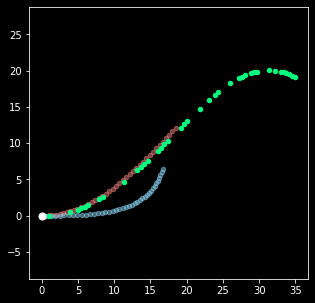

------------ 4 + 5 -----------
[[0.027943]]
[[0.06582955]]
[[0.05588599]]
-----------------------
[[0.02700814]]
[[0.03717369]]
[[0.06418183]]
[[0.0639461]]
-----------------------
[[0.02792826]]
[[0.02886114]]
[[0.02979578]]
[[0.03065124]]
[[0.03161925]]
[[0.03250871]]
[[0.03353744]]
[[0.03444172]]
[[0.03532972]]
[[0.03632073]]
[[0.0371989]]
[[0.03822625]]
[[0.03914533]]
[[0.04016821]]
[[0.04112478]]
[[0.04232344]]
[[0.04328673]]
[[0.04415597]]
[[0.04527318]]
[[0.04622865]]
[[0.04725326]]
[[0.04824425]]
[[0.04922056]]
[[0.05028119]]
[[0.05081714]]
[[0.05196489]]
[[0.05276591]]
[[0.05353352]]
[[0.05487309]]
[[0.05584897]]
[[0.05668643]]
[[0.05768259]]
[[0.05884429]]
[[0.05931638]]
[[0.06039357]]
[[0.06136679]]
[[0.0624436]]
[[0.06316773]]
[[0.0643376]]
[[0.06517632]]
[[0.06587999]]
[[0.06691404]]
[[0.06766287]]
[[0.06850585]]
[[0.06959929]]
[[0.07012027]]
[[0.07151217]]
[[0.07218137]]
[[0.07314337]]
[[0.07431804]]
[[0.07497118]]
[[0.07577198]]
[[0.07669874]]
[[0.07776813]]
[[0.07849917

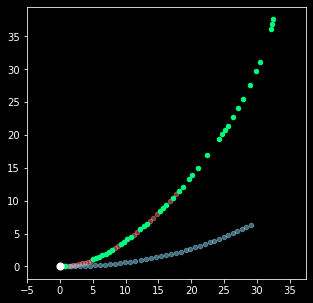

------------ 4 + 5 -----------
[[0.02795246]]
[[0.07077064]]
[[0.05590492]]
-----------------------
[[0.02686251]]
[[0.04213521]]
[[0.06899772]]
[[0.0691636]]
-----------------------
[[0.02789943]]
[[0.02904312]]
[[0.03004581]]
[[0.03113401]]
[[0.03224704]]
[[0.03338079]]
[[0.03467487]]
[[0.03591091]]
[[0.03708292]]
[[0.03815529]]
[[0.03973338]]
[[0.04074523]]
[[0.0416371]]
[[0.04263248]]
[[0.04437128]]
[[0.04541667]]
[[0.04650776]]
[[0.04774359]]
[[0.04871065]]
[[0.04994943]]
[[0.05097362]]
[[0.05185854]]
[[0.0535316]]
[[0.05423567]]
[[0.05554174]]
[[0.05679547]]
[[0.05785388]]
[[0.05856919]]
[[0.06010783]]
[[0.06071956]]
[[0.06191447]]
[[0.06240237]]
[[0.06353847]]
[[0.06462683]]
[[0.06565443]]
[[0.06628951]]
[[0.06729478]]
[[0.06860138]]
[[0.06929101]]
[[0.06998806]]
[[0.07072686]]
[[0.07186057]]
[[0.07256468]]
[[0.07346213]]
[[0.07385696]]
[[0.07455607]]
[[0.07523823]]
[[0.07603285]]
[[0.07698482]]
[[0.07724745]]
[[0.07830989]]
[[0.07868869]]
[[0.07976749]]
[[0.08026698]]
[[0.08140

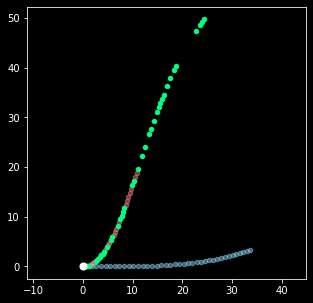

------------ 4 + 5 -----------
[[0.02580734]]
[[0.05231168]]
[[0.05161467]]
-----------------------
[[0.02514389]]
[[0.02607943]]
[[0.05122332]]
[[0.05111171]]
-----------------------
[[0.02581104]]
[[0.02648294]]
[[0.02717288]]
[[0.02784295]]
[[0.02847214]]
[[0.02909435]]
[[0.02976192]]
[[0.03047684]]
[[0.03111361]]
[[0.03174874]]
[[0.03240328]]
[[0.03314647]]
[[0.03373805]]
[[0.03443517]]
[[0.03502436]]
[[0.03585605]]
[[0.03647098]]
[[0.03713814]]
[[0.03776232]]
[[0.03848117]]
[[0.03924614]]
[[0.03984766]]
[[0.04066096]]
[[0.04132907]]
[[0.04199856]]
[[0.04268835]]
[[0.04327482]]
[[0.04388309]]
[[0.04461179]]
[[0.04559811]]
[[0.04595493]]
[[0.04668062]]
[[0.04747979]]
[[0.04810516]]
[[0.04863545]]
[[0.04934813]]
[[0.04991752]]
[[0.05065428]]
[[0.05128196]]
[[0.05157021]]
[[0.05232819]]
[[0.05294603]]
[[0.05370674]]
[[0.05402995]]
[[0.05446189]]
[[0.05522105]]
[[0.0557805]]
[[0.05613134]]
[[0.0568254]]
[[0.05727628]]
[[0.05797107]]
[[0.05845306]]
[[0.05885094]]
[[0.05931274]]
[[0.0596

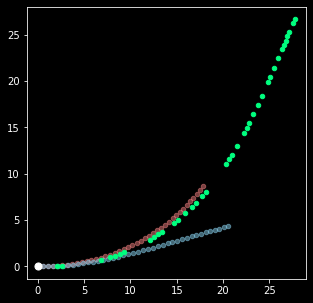

In [44]:
sample_points = 40
supporting_points_count = 40
max_offset = 4
limit = 40
numpy.random.seed(60)

torch.set_default_dtype(torch.float64)
device = torch.device('cuda')
model = DeepSignatureArcLengthNet(sample_points=sample_points).cuda()
model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
# model.load_state_dict(torch.load("C:/deep-signature-data/level-curves/results/tuplets/arclength/2021-01-14-02-42-52/model_349.pt", map_location=device))
model.eval()

curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
numpy.random.shuffle(curves)
curves = curves[:limit]
color_map = plt.get_cmap('rainbow', limit)

for curve_index, curve in enumerate(curves):
    if curve_index == 25:
        break
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.axis('equal')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)

    # for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    #     label.set_fontsize(30)

    # for label in (ax[2].get_xticklabels() + ax[2].get_yticklabels()):
    #     label.set_fontsize(30)    

    # plot curve
    # plot_curve(ax=ax[0], curve=curve, color=color_map(curve_index), linewidth=5)

    # plot predicted curvature
    predicted_arclength = numpy.zeros(curve.shape[0])
    for i in range(curve.shape[0]):
        if i == 1:
            break

        # sample = curve_sampling.sample_curve_section(
        #     curve=curve,
        #     supporting_points_count=supporting_points_count,
        #     start_point_index=i,
        #     end_point_index=i+supporting_points_count)
        # sample = curve_processing.normalize_curve(curve=sample, force_ccw=False, index1=0, index2=1, center_index=0)
        # batch_data = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample).double(), dim=0), dim=0).cuda()
        # with torch.no_grad():
        #     predicted_arclength[i] = torch.squeeze(model(batch_data), dim=0).cpu().detach().numpy()


        sample1_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i,
            end_point_index=i+supporting_points_count - 1)
        sample1 = curve_processing.normalize_curve(curve=sample1_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data1 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample1).double(), dim=0), dim=0).cuda()

        sample2_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i+supporting_points_count - 1,
            end_point_index=i+2*supporting_points_count - 2)
        sample2 = curve_processing.normalize_curve(curve=sample2_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data2 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample2).double(), dim=0), dim=0).cuda()

        sample3_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i,
            end_point_index=i+2*supporting_points_count - 2)
        sample3 = curve_processing.normalize_curve(curve=sample3_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data3 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample3).double(), dim=0), dim=0).cuda()










        sample4_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i,
            end_point_index=i+supporting_points_count)
        sample4 = curve_processing.normalize_curve(curve=sample4_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data4 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample4).double(), dim=0), dim=0).cuda()

        sample5_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i,
            end_point_index=i+2*supporting_points_count)
        sample5 = curve_processing.normalize_curve(curve=sample5_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data5 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample5).double(), dim=0), dim=0).cuda()


        print('------------ 4 + 5 -----------')
        with torch.no_grad():
            s1 = torch.squeeze(model(batch_data4), dim=0).cpu().detach().numpy()
            s2 = torch.squeeze(model(batch_data5), dim=0).cpu().detach().numpy()
            print(s1)
            print(s2)
            print(2 * s1)
            print('-----------------------')








        plot_sample(
            ax=ax, 
            sample=sample1, 
            point_size=20,
            color='lightcoral',
            alpha=0.5,
            zorder=50)

        plot_sample(
            ax=ax, 
            sample=sample2, 
            point_size=20,
            color='skyblue',
            alpha=0.5,
            zorder=50)

        plot_sample(
            ax=ax, 
            sample=sample3, 
            point_size=20,
            color='springgreen',
            zorder=150)

        plot_sample(ax, numpy.array([[sample1[0,0] ,sample1[0, 1]]]), point_size=50, alpha=1, color='white', zorder=200)

        with torch.no_grad():
            s1 = torch.squeeze(model(batch_data1), dim=0).cpu().detach().numpy()
            s2 = torch.squeeze(model(batch_data2), dim=0).cpu().detach().numpy()
            s3 = torch.squeeze(model(batch_data3), dim=0).cpu().detach().numpy()
            print(s1)
            print(s2)
            print(s1+s2)
            print(s3)
            print('-----------------------')







        for j in range(60):
            sample1 = curve_sampling.sample_curve_section2(
                curve=curve,
                supporting_points_count=sample_points,
                start_point_index=i,
                end_point_index=i+supporting_points_count + j)
            sample1 = curve_processing.normalize_curve(curve=sample1, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
            batch_data1 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample1).double(), dim=0), dim=0).cuda()
            with torch.no_grad():
                s1 = torch.squeeze(model(batch_data1), dim=0).cpu().detach().numpy()
                print(s1)
            
        print('-----------------------')




    # plot_curvature(ax=ax[1], curvature=predicted_curvature, color=color_map(curve_index), linewidth=5)

    # plot ground-truth curvature
    # gt_arclength = curve_processing.calculate_arclength(curve=curve)
    # plot_curvature(ax=ax[2], curvature=gt_arclength, color=color_map(curve_index), linewidth=5)

    plt.show()